In [31]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet50
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import imutils

Loading the fine-tuned model

In [11]:
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        # Load pre-trained ResNet-50 model with imagenet weights
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
                
        
        for param in self.base_model.parameters():
            param.requires_grad = True  # Unfreeze all layers for training

        # Replacing the final fully connected layer and adding a classification layer
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, num_classes),  
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.base_model(x)

# Initialize the custom model
model = BrainTumorClassifier(num_classes=4)  # 4 classes: glioma, meningioma, pituitary, no tumor

# Load the fine-tuned weights with CPU mapping
checkpoint = torch.load('./Model/resnet-50_finetuned.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

# Set the model to evaluation mode
model.eval()

C:\Users\mahat\AppData\Local\Temp\ipykernel_16904\213008249.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./Model/resnet-50_finetuned.pth', m

BrainTumorClassifier(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [23]:
def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular region.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply thresholding to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    # Remove small noise using erosion & dilation
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours from the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # If no contours found, return the original image
    if len(cnts) == 0:
        return img  

    # Find the largest contour (assuming it's the tumor region)
    c = max(cnts, key=cv2.contourArea)

    # Get extreme points of the contour (bounding box)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Add some padding (helps prevent cropping errors)
    ADD_PIXELS = 5
    y1, y2 = max(0, extTop[1] - ADD_PIXELS), min(img.shape[0], extBot[1] + ADD_PIXELS)
    x1, x2 = max(0, extLeft[0] - ADD_PIXELS), min(img.shape[1], extRight[0] + ADD_PIXELS)

    # Crop the image
    new_img = img[y1:y2, x1:x2].copy()
    
    return new_img


In [45]:
def preprocess_image(image_path):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = crop_img(img)  # Apply cropping
    img = cv2.resize(img, (224, 224))  # Resize to 224x224
    img = cv2.bilateralFilter(img, 2, 50, 50)  # Apply bilateral filtering
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)  # Apply colormap
    
    # Convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor, img

In [56]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        def save_gradient(module, grad_input, grad_output):
            if len(grad_output) > 0:
                self.gradients = grad_output[0].detach()
        
        def save_activation(module, input, output):
            self.activations = output.detach()
        
        # Register hooks
        target_layer.register_forward_hook(save_activation)
        target_layer.register_full_backward_hook(save_gradient)
    
    def __call__(self, x, class_idx=None):
        # Get model output
        model_output = self.model(x)
        
        if class_idx is None:
            class_idx = model_output.argmax(dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Get target score
        target_score = model_output[0, class_idx]
        
        # Backward pass
        target_score.backward()
        
        # Get weights
        weights = torch.mean(self.gradients, dim=(2, 3))
        
        # Generate CAM
        batch_size, channels, height, width = self.activations.shape
        cam = torch.zeros(height, width, dtype=torch.float32, device=x.device)
        
        # Weighted sum of activation maps
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]
        
        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), 
                          size=(224, 224), 
                          mode='bilinear', 
                          align_corners=False)
        
        cam = cam.squeeze()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)
        
        return cam.cpu().numpy()

In [67]:
target_layers = [
    model.base_model.layer4[-1].conv3,  # Last conv layer
]

In [68]:
# Test the implementation
def visualize_layer(model, layer, image_path):
    # Load and preprocess image
    input_tensor, original_image = preprocess_image(image_path)
    
    # Initialize GradCAM
    grad_cam = GradCAM(model, layer)
    
    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        confidence = F.softmax(output, dim=1)[0, pred_class].item()
        class_name = ['glioma', 'meningioma', 'pituitary', 'notumor'][pred_class]
    
    # Generate CAM
    cam = grad_cam(input_tensor, pred_class)
    
    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Overlay on original image
    superimposed = heatmap * 0.4 + cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) * 0.6
    superimposed = np.uint8(superimposed)
    
    return superimposed, class_name, confidence


c:\Users\mahat\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


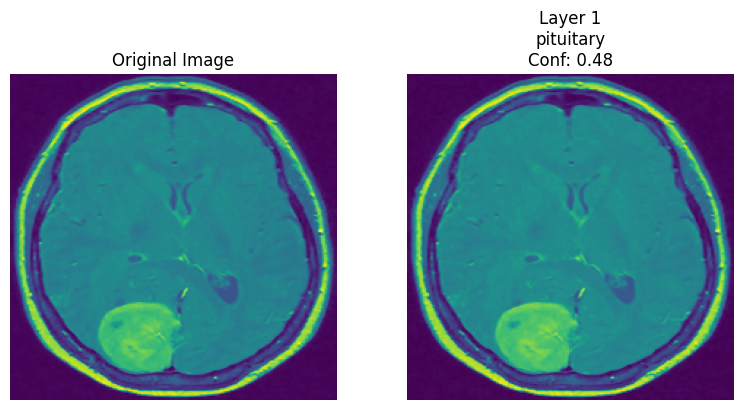

In [74]:
# Visualize results for each layer
image_path = 'Brain_Tumor_MRI_Dataset\Testing\meningioma\Te-me_0010.jpg'

plt.figure(figsize=(20, 4))

# Show original image
input_tensor, original_image = preprocess_image(image_path)
plt.subplot(1, 5, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY))
plt.title('Original Image')
plt.axis('off')

# Generate visualization for each layer
for idx, layer in enumerate(target_layers):
    superimposed, class_name, confidence = visualize_layer(model, layer, image_path)
    plt.subplot(1, 5, idx + 2)
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2GRAY))
    if idx == 0:  # Only show prediction on first visualization
        plt.title(f'Layer {idx+1}\n{class_name}\nConf: {confidence:.2f}')
    else:
        plt.title(f'Layer {idx+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()